In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.graph_objects as go
import datetime



## Data Collection

In [2]:
ticker = "HMN.SI"
start_date = "2015-01-01"
end_date = "2025-03-16"

df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

[*********************100%***********************]  1 of 1 completed


In [3]:
df

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,HMN.SI,HMN.SI,HMN.SI,HMN.SI,HMN.SI,HMN.SI
Date,,,,,,
2015-01-02,0.685858,1.217720,1.217720,1.208132,1.208132,276376
2015-01-05,0.683158,1.212926,1.222514,1.208132,1.212926,1085692
2015-01-06,0.688558,1.222514,1.222514,1.212926,1.217720,1400657
2015-01-07,0.685858,1.217720,1.222514,1.217720,1.222514,645574
2015-01-08,0.688558,1.222514,1.222514,1.217720,1.222514,793671
...,...,...,...,...,...,...
2025-03-10,0.865000,0.865000,0.870000,0.860000,0.865000,5147100
2025-03-11,0.865000,0.865000,0.870000,0.860000,0.860000,5171000


In [4]:
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

In [5]:
df

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2015-01-02,0.685858,1.217720,1.217720,1.208132,1.208132,276376
2015-01-05,0.683158,1.212926,1.222514,1.208132,1.212926,1085692
2015-01-06,0.688558,1.222514,1.222514,1.212926,1.217720,1400657
2015-01-07,0.685858,1.217720,1.222514,1.217720,1.222514,645574
2015-01-08,0.688558,1.222514,1.222514,1.217720,1.222514,793671
...,...,...,...,...,...,...
2025-03-10,0.865000,0.865000,0.870000,0.860000,0.865000,5147100
2025-03-11,0.865000,0.865000,0.870000,0.860000,0.860000,5171000
2025-03-12,0.880000,0.880000,0.880000,0.865000,0.865000,10647900


In [6]:
df = df.rename(columns={'Close': 'GT'})
df

Price,Adj Close,GT,High,Low,Open,Volume
Date,,,,,,
2015-01-02,0.685858,1.217720,1.217720,1.208132,1.208132,276376
2015-01-05,0.683158,1.212926,1.222514,1.208132,1.212926,1085692
2015-01-06,0.688558,1.222514,1.222514,1.212926,1.217720,1400657
2015-01-07,0.685858,1.217720,1.222514,1.217720,1.222514,645574
2015-01-08,0.688558,1.222514,1.222514,1.217720,1.222514,793671
...,...,...,...,...,...,...
2025-03-10,0.865000,0.865000,0.870000,0.860000,0.865000,5147100
2025-03-11,0.865000,0.865000,0.870000,0.860000,0.860000,5171000
2025-03-12,0.880000,0.880000,0.880000,0.865000,0.865000,10647900


In [7]:
print(df['GT'].dtypes)
print(df['GT'].describe())


float64
count    2561.000000
mean        1.077735
std         0.122939
min         0.685000
25%         1.000000
50%         1.083483
75%         1.160000
max         1.420000
Name: GT, dtype: float64


### Visualize Data

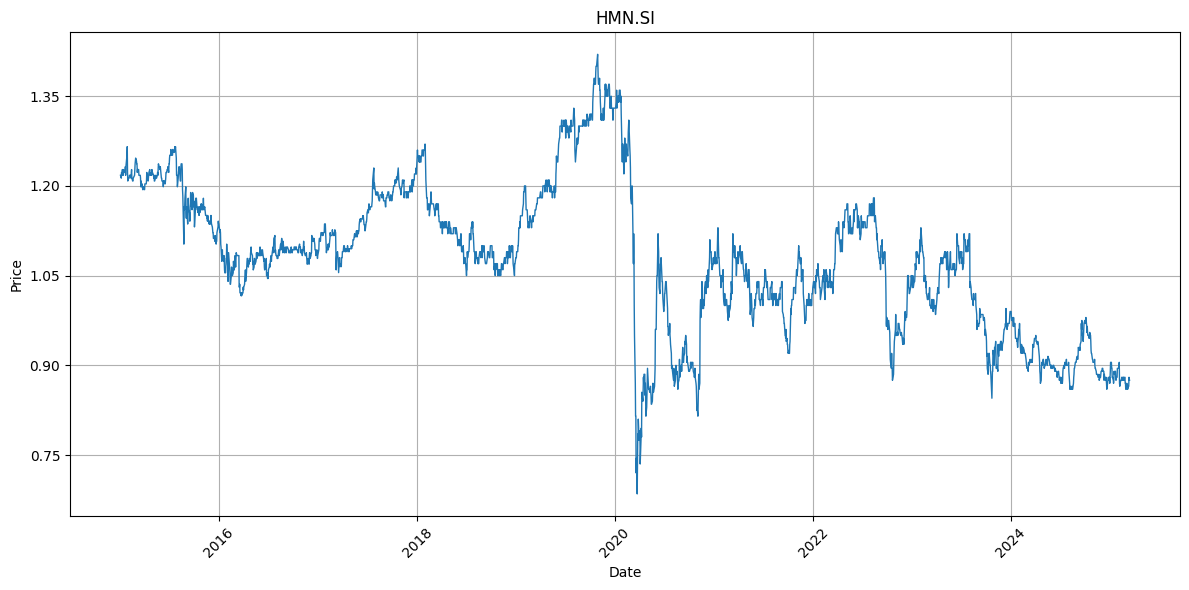

In [8]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['GT'], linewidth=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('HMN.SI')

# Format y-axis ticks to 2 decimal places
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

# Automatically reduce number of y-axis ticks (matplotlib does it smartly)
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(nbins=8))  # Limit to ~8 y-axis ticks

# Rotate x-axis ticks to avoid overlap
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



## Standardize data 

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_prices = scaler.fit_transform(df['GT'].values.reshape(-1,1))
scaled_prices

array([[0.7247892 ],
       [0.71826675],
       [0.73131165],
       ...,
       [0.26530613],
       [0.25850341],
       [0.25850341]], shape=(2561, 1))

## Construct datasets

In [10]:
MOVING_WINDOW = 60
all_x, all_y = [], []
for i in range(len(scaled_prices) - MOVING_WINDOW):
    all_x.append(scaled_prices[i:i+MOVING_WINDOW]) #first 60 price
    all_y.append(scaled_prices[i+MOVING_WINDOW]) #61st price

all_x = np.array(all_x)
all_y = np.array(all_y)

In [11]:
all_x.shape, all_y.shape

((2501, 60, 1), (2501, 1))

## Split dataset

In [12]:
DS_SPLIT = 0.8

train_ds_size = round(all_x.shape[0] * DS_SPLIT)
train_x, train_y = all_x[:train_ds_size], all_y[:train_ds_size]
test_x, test_y = all_x[train_ds_size:], all_y[train_ds_size:]

In [13]:
train_x.shape

(2001, 60, 1)

In [14]:
train_y.shape

(2001, 1)

In [15]:
test_x.shape

(500, 60, 1)

In [17]:
test_y.shape

(500, 1)

## Construct Model

In [ ]:
'''
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_x.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.summary()
'''

c:\Users\Jesus\anaconda3\envs\lstm\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
'''
model.compile(optimizer='adam', loss='mean_squared_error')
'''

## Train Model

In [ ]:
'''
callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(train_x, train_y,
          validation_split=0.2,
          callbacks=[callback],
          epochs=200)

model.save('hmn.keras') 
'''

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0887 - val_loss: 0.0051
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 12/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

In [18]:
model = load_model('c2pu.keras')
preds = model.predict(test_x)
preds

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[0.43709853],
       [0.44382286],
       [0.42637116],
       [0.4293633 ],
       [0.44192445],
       [0.43637496],
       [0.4282239 ],
       [0.43053648],
       [0.42209715],
       [0.41392463],
       [0.41660494],
       [0.42340526],
       [0.44077677],
       [0.4565908 ],
       [0.46047893],
       [0.4701515 ],
       [0.46249804],
       [0.4793291 ],
       [0.49611333],
       [0.5109852 ],
       [0.5249311 ],
       [0.52792025],
       [0.5381693 ],
       [0.53012866],
       [0.53763485],
       [0.5405065 ],
       [0.53012955],
       [0.5268182 ],
       [0.5373757 ],
       [0.54083663],
       [0.54098576],
       [0.5513172 ],
       [0.54307705],
       [0.5396596 ],
       [0.5499008 ],
       [0.5421888 ],
       [0.51752806],
       [0.5108444 ],
       [0.52161705],
       [0.54747456],
       [0.5220552 ],
       [0.4803433 ],
       [0.47978383],
       [0.5042885 ],
       [0.5129038 ],
       [0.5352933 ],
       [0.5519242 ],
       [0.533

In [19]:
preds = scaler.inverse_transform(preds) #convert back to original scale
preds

array([[1.0062674 ],
       [1.0112098 ],
       [0.99838275],
       [1.000582  ],
       [1.0098145 ],
       [1.0057355 ],
       [0.99974453],
       [1.0014443 ],
       [0.99524134],
       [0.98923457],
       [0.99120456],
       [0.9962029 ],
       [1.0089709 ],
       [1.0205942 ],
       [1.0234519 ],
       [1.0305613 ],
       [1.0249361 ],
       [1.0373069 ],
       [1.0496433 ],
       [1.060574  ],
       [1.0708244 ],
       [1.0730214 ],
       [1.0805544 ],
       [1.0746446 ],
       [1.0801616 ],
       [1.0822723 ],
       [1.0746452 ],
       [1.0722114 ],
       [1.0799711 ],
       [1.0825149 ],
       [1.0826244 ],
       [1.0902182 ],
       [1.0841615 ],
       [1.0816498 ],
       [1.089177  ],
       [1.0835087 ],
       [1.0653831 ],
       [1.0604706 ],
       [1.0683886 ],
       [1.0873938 ],
       [1.0687106 ],
       [1.0380523 ],
       [1.037641  ],
       [1.055652  ],
       [1.0619843 ],
       [1.0784405 ],
       [1.0906643 ],
       [1.076

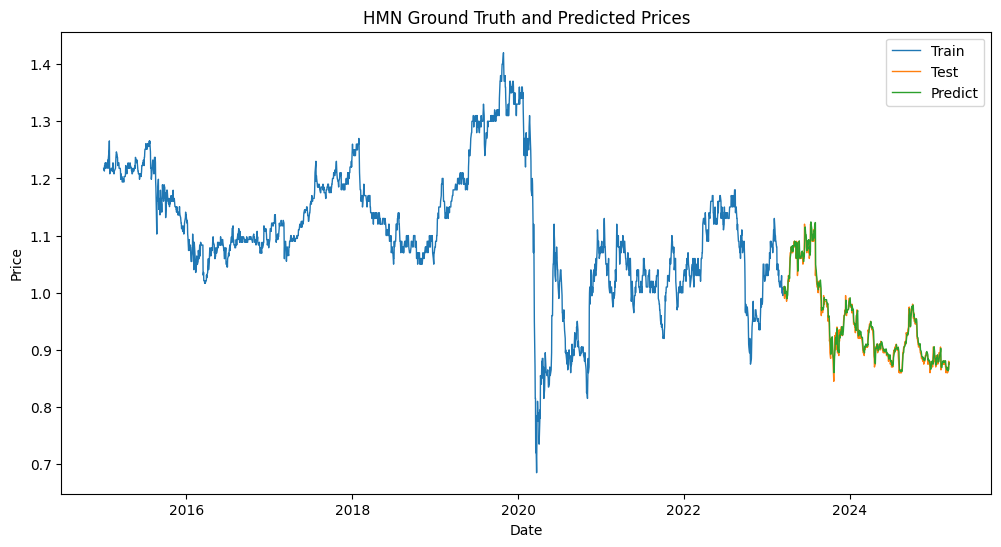

In [20]:
train_df = df[:train_ds_size+MOVING_WINDOW]
test_df = df[train_ds_size+MOVING_WINDOW:]
test_df = test_df.assign(Predict = preds)
plt.figure(figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(train_df["GT"], linewidth=1)
plt.plot(test_df["GT"], linewidth=1)
plt.plot(test_df["Predict"], linewidth=1)
plt.legend(["Train", "Test", "Predict"])
plt.title("HMN Ground Truth and Predicted Prices")
plt.show()

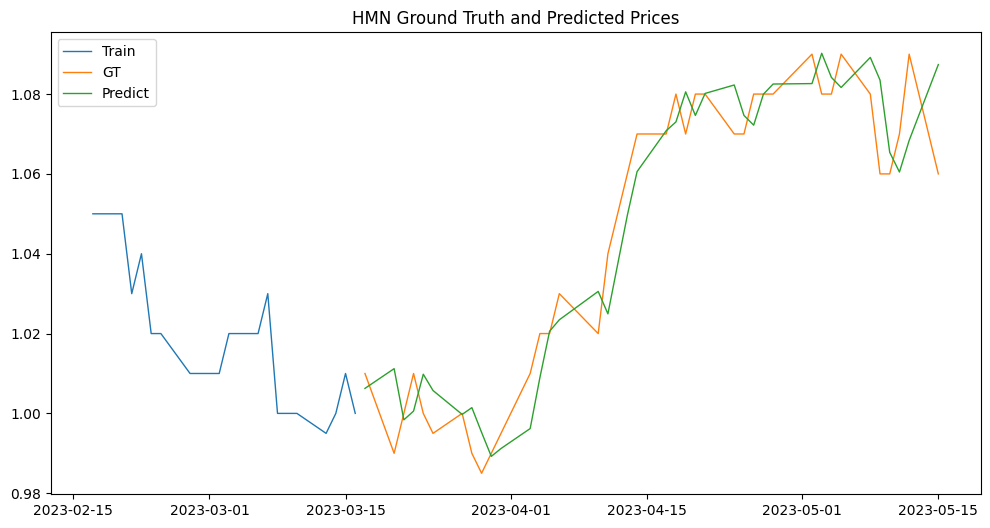

In [21]:
#zoom in
plt.figure(figsize=(12, 6))
plt.plot(train_df["GT"][-20:], linewidth=1)
plt.plot(test_df["GT"][:40], linewidth=1)
plt.plot(test_df["Predict"][:40], linewidth=1)
plt.legend(["Train", "GT", "Predict"])
plt.title("HMN Ground Truth and Predicted Prices")
plt.show()

In [28]:
y_true = test_df["GT"]
y_pred = test_df["Predict"]

# Calculate evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Print the results
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"R-squared (R²): {r2:.6f}")

Mean Absolute Error (MAE): 0.007991
Mean Squared Error (MSE): 0.000132
Root Mean Squared Error (RMSE): 0.011484
R-squared (R²): 0.973051


In [ ]:
test_df

Price,Adj Close,GT,High,Low,Open,Volume,Predict
Date,,,,,,,
2023-03-17,0.913359,1.010,1.01,1.000,1.010,3322800,1.006267
2023-03-20,0.895273,0.990,1.01,0.990,1.010,4345900,1.011210
2023-03-21,0.904316,1.000,1.01,1.000,1.000,5617700,0.998383
2023-03-22,0.913359,1.010,1.01,0.995,1.010,4835200,1.000582
2023-03-23,0.904316,1.000,1.02,1.000,1.000,4123000,1.009815
...,...,...,...,...,...,...,...
2025-03-10,0.865000,0.865,0.87,0.860,0.865,5147100,0.863460
2025-03-11,0.865000,0.865,0.87,0.860,0.860,5171000,0.865182
2025-03-12,0.880000,0.880,0.88,0.865,0.865,10647900,0.866303


In [ ]:
test_df['GT_tmr'] = test_df['GT'].shift(1)
test_df.dropna(subset=['GT_tmr'], inplace=True)

test_df

Price,Adj Close,GT,High,Low,Open,Volume,Predict,GT_tmr
Date,,,,,,,,
2023-03-17,0.913359,1.010,1.010,1.000,1.010,3322800,1.006267,0.990
2023-03-20,0.895273,0.990,1.010,0.990,1.010,4345900,1.011210,1.000
2023-03-21,0.904316,1.000,1.010,1.000,1.000,5617700,0.998383,1.010
2023-03-22,0.913359,1.010,1.010,0.995,1.010,4835200,1.000582,1.000
2023-03-23,0.904316,1.000,1.020,1.000,1.000,4123000,1.009815,0.995
...,...,...,...,...,...,...,...,...
2025-03-07,0.860000,0.860,0.875,0.860,0.865,7359000,0.865810,0.865
2025-03-10,0.865000,0.865,0.870,0.860,0.865,5147100,0.863460,0.865
2025-03-11,0.865000,0.865,0.870,0.860,0.860,5171000,0.865182,0.880


In [27]:
results = {}

# Loop through the prediction columns
for col in ["Predict", "GT_tmr"]:
    y_true = test_df["GT"]
    y_pred = test_df[col]

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    results[col] = [mae, mse, rmse, r2]

# Convert to DataFrame for a clean display
metrics_df = pd.DataFrame(results, index=["MAE", "MSE", "RMSE", "R2"])
print(metrics_df)

       Predict    GT_tmr
MAE   0.007991  0.007325
MSE   0.000132  0.000122
RMSE  0.011484  0.011027
R2    0.973051  0.975155


## Next-Day Predictive Trading Strategy

In [ ]:
# Parameters
initial_capital = 10000
percent_of_equity = 0.8
stop_loss = 0.1  
capital = initial_capital
position = None  
entry_price = 0  
equity = initial_capital  
trade_log = [] 

# Iterate through the DataFrame
for i in range(1, len(test_df) - 1): 
    current_price = test_df['GT'].iloc[i]  # Ground truth
    next_predicted_price = test_df['Predict'].iloc[i + 1]  # Predicted price 
    date = test_df.index[i] 

    # Check if a position is active
    if position == 'long':
        # Check for stop-loss or trend reversal
        if current_price <= entry_price * (1 - stop_loss) or next_predicted_price < current_price:
            # Close long position
            profit = (current_price - entry_price) * (capital * percent_of_equity / entry_price)
            equity += profit
            trade_log.append({'Date': date, 'Action': 'Close Long', 'Price': current_price, 'Profit': profit, 'Equity': equity})
            position = None

    elif position == 'short':
        # Check for stop-loss or trend reversal
        if current_price >= entry_price * (1 + stop_loss) or next_predicted_price > current_price:
            # Close short position
            profit = (entry_price - current_price) * (capital * percent_of_equity / entry_price)
            equity += profit
            trade_log.append({'Date': date, 'Action': 'Close Short', 'Price': current_price, 'Profit': profit, 'Equity': equity})
            position = None

    # If no position is active, check for entry signals
    if position is None:
        if next_predicted_price > current_price:
            # Open long position
            entry_price = current_price
            position = 'long'
            trade_log.append({'Date': date, 'Action': 'Open Long', 'Price': current_price, 'Profit': 0, 'Equity': equity})
        elif next_predicted_price < current_price:
            # Open short position
            entry_price = current_price
            position = 'short'
            trade_log.append({'Date': date, 'Action': 'Open Short', 'Price': current_price, 'Profit': 0, 'Equity': equity})


trade_log_df = pd.DataFrame(trade_log)

# Calculate metrics
closed_trades = trade_log_df[trade_log_df['Action'].str.contains('Close')]  
gross_profit = closed_trades[closed_trades['Profit'] > 0]['Profit'].sum()  
gross_loss = closed_trades[closed_trades['Profit'] < 0]['Profit'].sum()  
net_profit = gross_profit + gross_loss  

# Buy-and-Hold Return
initial_price = test_df['GT'].iloc[0] 
final_price = test_df['GT'].iloc[-1] 
buy_and_hold_return = ((final_price - initial_price) / initial_price) * 100  

# Display results
print(f"Gross Profit: ${gross_profit:.2f}")
print(f"Gross Loss: ${gross_loss:.2f}")
print(f"Net Profit: ${net_profit:.2f}")
print(f"Buy-and-Hold Return: {buy_and_hold_return:.2f}%")

# Display the trade log
print(trade_log_df)

# Final equity
print(f"Final Equity: ${equity:.2f}")

Gross Profit: $9351.34
Gross Loss: $-8094.66
Net Profit: $1256.68
Buy-and-Hold Return: -13.37%
          Date       Action  Price      Profit        Equity
0   2023-03-20    Open Long  0.990    0.000000  10000.000000
1   2023-03-22   Close Long  1.010  161.616006  10161.616006
2   2023-03-22   Open Short  1.010    0.000000  10161.616006
3   2023-03-23  Close Short  1.000   79.207846  10240.823852
4   2023-03-23    Open Long  1.000    0.000000  10240.823852
..         ...          ...    ...         ...           ...
348 2025-03-05    Open Long  0.860    0.000000  11025.176900
349 2025-03-12   Close Long  0.880  186.046331  11211.223231
350 2025-03-12   Open Short  0.880    0.000000  11211.223231
351 2025-03-13  Close Short  0.875   45.454502  11256.677733
352 2025-03-13    Open Long  0.875    0.000000  11256.677733

[353 rows x 5 columns]
Final Equity: $11256.68


In [ ]:
# Extract series
dates = test_df.index
gt = test_df['GT']
predict = test_df['Predict']

# Separate long/short entries & exits from the trade log
entry_long = trade_log_df[trade_log_df['Action'].str.contains("Open Long")]
entry_short = trade_log_df[trade_log_df['Action'].str.contains("Open Short")]
exit_long = trade_log_df[trade_log_df['Action'].str.contains("Close Long")]
exit_short = trade_log_df[trade_log_df['Action'].str.contains("Close Short")]

# Create the interactive plot
fig = go.Figure()

# Ground truth price line
fig.add_trace(go.Scatter(x=dates, y=gt, mode='lines', name='GT (Actual)', line=dict(color='blue')))

# Predicted price line
fig.add_trace(go.Scatter(x=dates, y=predict, mode='lines', name='Predicted', line=dict(color='orange')))

# Entry Long signals
fig.add_trace(go.Scatter(
    x=entry_long['Date'], y=entry_long['Price'],
    mode='markers',
    name='Buy Signal',
    marker=dict(symbol='triangle-up', size=10, color='green')
))

# Entry Short signals
fig.add_trace(go.Scatter(
    x=entry_short['Date'], y=entry_short['Price'],
    mode='markers',
    name='Sell Signal',
    marker=dict(symbol='triangle-down', size=10, color='red')
))

# Exit Long signals
fig.add_trace(go.Scatter(
    x=exit_long['Date'], y=exit_long['Price'],
    mode='markers',
    name='Exit Long',
    marker=dict(symbol='x', size=9, color='lime')
))

# Exit Short signals
fig.add_trace(go.Scatter(
    x=exit_short['Date'], y=exit_short['Price'],
    mode='markers',
    name='Exit Short',
    marker=dict(symbol='x', size=9, color='purple')
))

# Layout settings
fig.update_layout(
    title='Next-Day Predictive Trading Strategy',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend',
    template='plotly_white',
    hovermode='closest'
)

fig.show()


## Append news analysis result

In [ ]:
sentiment_df = pd.read_csv('../news_analysis_code/hmn_news_data.csv', usecols=['date', 'sentiment', 'sentiment_score'])
sentiment_df.columns = ['Date', 'Sentiment', 'Sentiment Score']
sentiment_df.head()

,Date,Sentiment,Sentiment Score
0,2024-12-19,neutral,0.949041
1,2025-02-19,positive,0.951268
2,2025-02-19,neutral,0.919325
3,2024-12-02,neutral,0.931843
4,2025-02-19,negative,0.958255


In [ ]:
# rearrange the date
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])

# Keep only the row with the highest sentiment score
sentiment_df = sentiment_df.loc[sentiment_df.groupby('Date')['Sentiment Score'].idxmax()].reset_index(drop=True)

sentiment_df.head()

,Date,Sentiment,Sentiment Score
0,2013-11-20,neutral,0.895455
1,2017-05-26,neutral,0.934522
2,2018-09-03,neutral,0.928349
3,2018-09-21,neutral,0.863116
4,2019-01-12,neutral,0.940874


In [ ]:
sentiment_df['Sentiment'] = sentiment_df['Sentiment'].replace({
    'neutral': 0,
    'positive': 1,
    'negative': -1
})

sentiment_df.head()

C:\Users\Jesus\AppData\Local\Temp\ipykernel_20048\1101630648.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,Date,Sentiment,Sentiment Score
0,2013-11-20,0,0.895455
1,2017-05-26,0,0.934522
2,2018-09-03,0,0.928349
3,2018-09-21,0,0.863116
4,2019-01-12,0,0.940874


In [ ]:
sentiment_df.dtypes

Date               datetime64[ns]
Sentiment                   int64
Sentiment Score           float64
dtype: object

In [ ]:
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
sentiment_df = sentiment_df.set_index('Date')

In [ ]:
#keep only matching dates
merged_df = pd.merge(test_df, sentiment_df, on='Date', how='left')
merged_df.head()

,Adj Close,GT,High,Low,Open,Volume,Predict,Sentiment,Sentiment Score
Date,,,,,,,,,
2023-03-17,0.913359,1.01,1.01,1.000,1.01,3322800,1.006267,NaN,NaN
2023-03-20,0.895273,0.99,1.01,0.990,1.01,4345900,1.011210,NaN,NaN
2023-03-21,0.904316,1.00,1.01,1.000,1.00,5617700,0.998383,NaN,NaN
2023-03-22,0.913359,1.01,1.01,0.995,1.01,4835200,1.000582,NaN,NaN
2023-03-23,0.904316,1.00,1.02,1.000,1.00,4123000,1.009815,NaN,NaN


In [ ]:
merged_df[50:80]

,Adj Close,GT,High,Low,Open,Volume,Predict,Sentiment,Sentiment Score
Date,,,,,,,,,
2023-05-30,0.958575,1.06,1.07,1.05,1.06,3241060,1.060776,NaN,NaN
2023-05-31,0.958575,1.06,1.07,1.05,1.06,8897200,1.061665,NaN,NaN
2023-06-01,0.967618,1.07,1.07,1.05,1.06,5908200,1.062280,NaN,NaN
2023-06-05,0.967618,1.07,1.08,1.06,1.07,4574900,1.070451,NaN,NaN
2023-06-06,0.958575,1.06,1.08,1.05,1.07,8396500,1.072948,NaN,NaN
2023-06-07,0.967618,1.07,1.07,1.05,1.05,3790400,1.065117,NaN,NaN
2023-06-08,0.958575,1.06,1.06,1.05,1.06,2807700,1.070253,NaN,NaN
2023-06-09,0.949532,1.05,1.06,1.05,1.06,1415900,1.064418,NaN,NaN
2023-06-12,0.958575,1.06,1.08,1.05,1.05,6991400,1.054455,NaN,NaN


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2023-03-17 to 2025-03-14
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Adj Close        500 non-null    float64
 1   GT               500 non-null    float64
 2   High             500 non-null    float64
 3   Low              500 non-null    float64
 4   Open             500 non-null    float64
 5   Volume           500 non-null    int64  
 6   Predict          500 non-null    float32
 7   Sentiment        78 non-null     float64
 8   Sentiment Score  78 non-null     float64
dtypes: float32(1), float64(7), int64(1)
memory usage: 37.1 KB


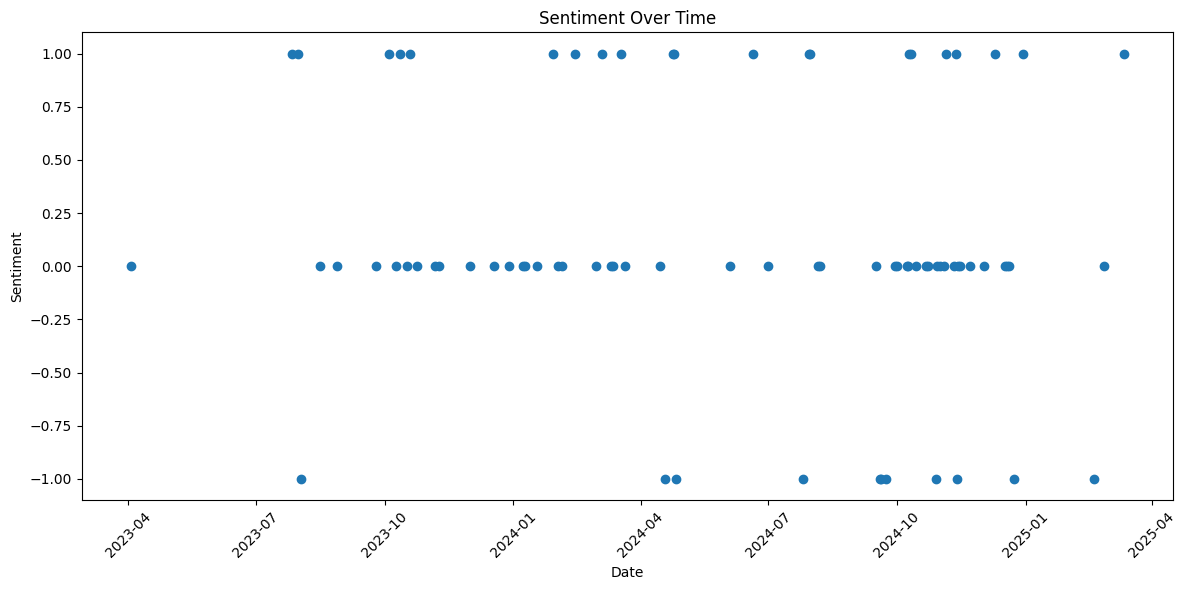

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Sentiment'], marker='o', linestyle='None')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.title('Sentiment Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

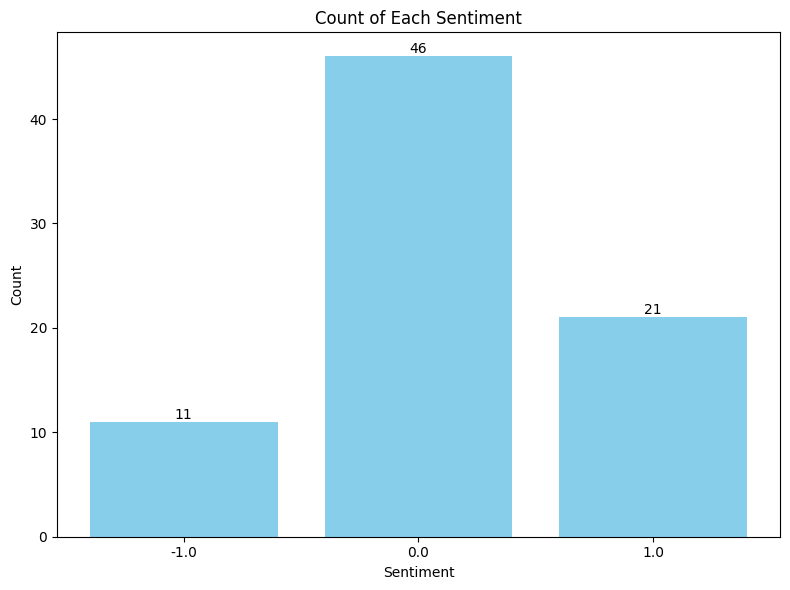

In [ ]:
sentiment_counts = merged_df['Sentiment'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
bars = plt.bar(sentiment_counts.index.astype(str), sentiment_counts.values, color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of Each Sentiment')

# Add the count above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)),
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
nan_count = merged_df['Sentiment'].isna().sum()
nan_count

np.int64(422)

In [ ]:
merged_df

,Adj Close,GT,High,Low,Open,Volume,Predict,Sentiment,Sentiment Score
Date,,,,,,,,,
2023-03-17,0.913359,1.010,1.01,1.000,1.010,3322800,1.006267,NaN,NaN
2023-03-20,0.895273,0.990,1.01,0.990,1.010,4345900,1.011210,NaN,NaN
2023-03-21,0.904316,1.000,1.01,1.000,1.000,5617700,0.998383,NaN,NaN
2023-03-22,0.913359,1.010,1.01,0.995,1.010,4835200,1.000582,NaN,NaN
2023-03-23,0.904316,1.000,1.02,1.000,1.000,4123000,1.009815,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2025-03-10,0.865000,0.865,0.87,0.860,0.865,5147100,0.863460,NaN,NaN
2025-03-11,0.865000,0.865,0.87,0.860,0.860,5171000,0.865182,NaN,NaN
2025-03-12,0.880000,0.880,0.88,0.865,0.865,10647900,0.866303,1.0,0.569413


## News-Driven Next-Day Predictive Trading Strategy

In [ ]:
initial_capital = 10000
percent_of_equity = 0.8
stop_loss = 0.2

capital = initial_capital
equity = initial_capital
trade_log = []
position = None
entry_price = None

i = 0
while i < len(test_df):
    # Forced exit condition on March 14, 2025
    if merged_df.index[i] == pd.Timestamp("2025-03-14"):
        if position is not None:
            exec_price = test_df['GT'].iloc[i]
            if position == 'long':
                profit = (exec_price - entry_price) * (capital * percent_of_equity / entry_price)
                trade_log.append({
                    'Date': test_df.index[i],
                    'Action': 'Forced Exit Long',
                    'Price': exec_price,
                    'Profit': profit,
                    'Equity': equity
                })
            elif position == 'short':
                profit = (entry_price - exec_price) * (capital * percent_of_equity / entry_price)
                trade_log.append({
                    'Date': test_df.index[i],
                    'Action': 'Forced Exit Short',
                    'Price': exec_price,
                    'Profit': profit,
                    'Equity': equity
                })
        break

    signal_price = merged_df['GT'].iloc[i]
    predicted_price = merged_df['Predict'].iloc[i]

    # Entry signals (same day)
    if position is None:
        if predicted_price > signal_price and (merged_df['Sentiment'].iloc[i] in [1, 0] or pd.isna(merged_df['Sentiment'].iloc[i])):
            position = 'long'
            entry_price = merged_df['GT'].iloc[i]
            trade_log.append({
                'Date': merged_df.index[i],
                'Action': 'Enter Long',
                'Price': entry_price,
                'Profit': 0,
                'Equity': equity
            })
        elif predicted_price < signal_price and (merged_df['Sentiment'].iloc[i] in [-1, 0] or pd.isna(merged_df['Sentiment'].iloc[i])):
            position = 'short'
            entry_price = merged_df['GT'].iloc[i]
            trade_log.append({
                'Date': merged_df.index[i],
                'Action': 'Enter Short',
                'Price': entry_price,
                'Profit': 0,
                'Equity': equity
            })
        i += 1
        continue

    # Exit conditions (same day)
    current_gt = merged_df['GT'].iloc[i]
    if position == 'long':
        if predicted_price < current_gt or current_gt <= entry_price * (1 - stop_loss) or merged_df['Sentiment'].iloc[i] == -1:
            profit = (current_gt - entry_price) * (capital * percent_of_equity / entry_price)
            equity += profit
            trade_log.append({
                'Date': merged_df.index[i],
                'Action': 'Exit Long',
                'Price': current_gt,
                'Profit': profit,
                'Equity': equity
            })
            position = None
    elif position == 'short':
        if predicted_price > current_gt or current_gt >= entry_price * (1 + stop_loss) or merged_df['Sentiment'].iloc[i] == 1:
            profit = (entry_price - current_gt) * (capital * percent_of_equity / entry_price)
            equity += profit
            trade_log.append({
                'Date': merged_df.index[i],
                'Action': 'Exit Short',
                'Price': current_gt,
                'Profit': profit,
                'Equity': equity
            })
            position = None
    i += 1

# Create DataFrame from trade log
trade_log_df = pd.DataFrame(trade_log)

# Summary metrics
closed_trades = trade_log_df[trade_log_df['Action'].str.contains('Exit')]
gross_profit = closed_trades[closed_trades['Profit'] > 0]['Profit'].sum()
gross_loss = closed_trades[closed_trades['Profit'] < 0]['Profit'].sum()
net_profit = gross_profit + gross_loss
buy_and_hold_return = ((test_df['GT'].iloc[-1] - test_df['GT'].iloc[0]) / test_df['GT'].iloc[0]) * 100

print(f"\n--- Strategy Summary ---")
print(f"Gross Profit: ${gross_profit:.2f}")
print(f"Gross Loss: ${gross_loss:.2f}")
print(f"Net Profit: ${net_profit:.2f}")
print(f"Buy-and-Hold Return: {buy_and_hold_return:.2f}%")
print(f"Final Equity: ${equity:.2f}")
print("\nTrade Log:")
print(trade_log_df)



--- Strategy Summary ---
Gross Profit: $7701.56
Gross Loss: $-5399.80
Net Profit: $2301.76
Buy-and-Hold Return: -13.37%
Final Equity: $12301.76

Trade Log:
          Date            Action  Price      Profit        Equity
0   2023-03-17       Enter Short  1.010    0.000000  10000.000000
1   2023-03-20        Exit Short  0.990  158.415692  10158.415692
2   2023-03-21       Enter Short  1.000    0.000000  10158.415692
3   2023-03-23        Exit Short  1.000    0.000000  10158.415692
4   2023-03-24        Enter Long  0.995    0.000000  10158.415692
..         ...               ...    ...         ...           ...
285 2025-03-10         Exit Long  0.865   46.511583  12163.027510
286 2025-03-11        Enter Long  0.865    0.000000  12163.027510
287 2025-03-12         Exit Long  0.880  138.728190  12301.755700
288 2025-03-13        Enter Long  0.875    0.000000  12301.755700
289 2025-03-14  Forced Exit Long  0.875    0.000000  12301.755700

[290 rows x 5 columns]


In [ ]:
# Extract series
dates = merged_df.index
gt = merged_df['GT']
predict = merged_df['Predict']

# Separate long/short entries & exits from the trade log
entry_long = trade_log_df[trade_log_df['Action'].str.contains("Enter Long")]
entry_short = trade_log_df[trade_log_df['Action'].str.contains("Enter Short")]
exit_long = trade_log_df[trade_log_df['Action'].str.contains("Exit Long")]
exit_short = trade_log_df[trade_log_df['Action'].str.contains("Exit Short")]

# Create the interactive plot
fig = go.Figure()

# Ground truth price line
fig.add_trace(go.Scatter(x=dates, y=gt, mode='lines', name='GT (Actual)', line=dict(color='blue')))

# Predicted price line
fig.add_trace(go.Scatter(x=dates, y=predict, mode='lines', name='Predicted', line=dict(color='orange')))

# Entry Long signals
fig.add_trace(go.Scatter(
    x=entry_long['Date'], y=entry_long['Price'],
    mode='markers',
    name='Buy Signal',
    marker=dict(symbol='triangle-up', size=10, color='green')
))

# Entry Short signals
fig.add_trace(go.Scatter(
    x=entry_short['Date'], y=entry_short['Price'],
    mode='markers',
    name='Sell Signal',
    marker=dict(symbol='triangle-down', size=10, color='red')
))

# Exit Long signals
fig.add_trace(go.Scatter(
    x=exit_long['Date'], y=exit_long['Price'],
    mode='markers',
    name='Exit Long',
    marker=dict(symbol='x', size=9, color='lime')
))

# Exit Short signals
fig.add_trace(go.Scatter(
    x=exit_short['Date'], y=exit_short['Price'],
    mode='markers',
    name='Exit Short',
    marker=dict(symbol='x', size=9, color='purple')
))

# Layout settings
fig.update_layout(
    title='News-Driven Next-Day Predictive Trading Strategy',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend',
    template='plotly_white',
    hovermode='closest'
)

fig.show()
